# Interactive Shadow Removal

In [4]:
from google.colab import files
fl = files.upload()

Saving shadowimage.png to shadowimage.png


In [0]:
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

from skimage import io
#from skimage.color import rgb2grey
from skimage.transform import resize, rescale
from skimage.filters import gaussian
from scipy.spatial.distance import cosine
from skimage.restoration import denoise_bilateral
import skimage.morphology as morph
from skimage import color

import scipy.spatial

import numpy as np

from matplotlib import pyplot as plt
from matplotlib.pyplot import figure

### Generating Masks

In [0]:
nm = 'shadowimage.png'
startPoint = (120,130)

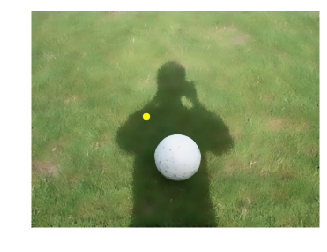

In [9]:
originalImage = io.imread(nm)[:,:,:3]
originalImage = np.uint8(255 * denoise_bilateral(originalImage,sigma_color=.06,
                                  sigma_spatial=8,multichannel=True))
originalImage = np.uint8(255 * rescale(originalImage, (0.5,0.5)))

imx, imy, _ = originalImage.shape
#print(imx,imy)

#startPoint = (120,130)#(100,130)#(120,130)

# Plotting/Displaying aspect
plt.imshow(originalImage)
plt.scatter(startPoint[1],startPoint[0],color="yellow")
plt.axis('off')
#plt.savefig('inout1.eps')
plt.show()

### Generating Shadow Seed

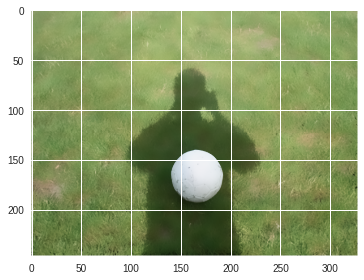

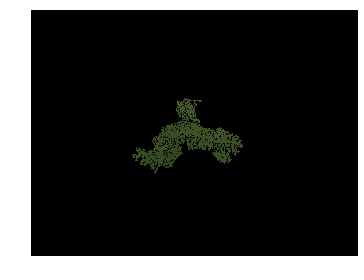

In [10]:
import queue
Q = queue.Queue(1024)
Q.put((startPoint,0))

#before .06, .04
useImage = np.array(originalImage)

io.imshow(useImage)
plt.show()

neighbours = [(1,0),(-1,0),(0,1),(0,-1)]
iterations = 100
finMask = np.zeros(useImage.shape[0:2])
# useImage to originalImage
colList = np.array(useImage[startPoint])[np.newaxis,:]

while not Q.empty():
  cur, lev = Q.get()
  for i in neighbours:
    x,y = (cur[0] + i[0], cur[1] + i[1])
    if x<0 or x>=imx or y<0 or y>=imy or finMask[x,y] != 0:
      continue
    
    score = useImage[cur] - useImage[x,y]
    score = np.sum(score ** 2)
    
    if score < 4:
      finMask[x,y] = 1
      if lev < iterations:
        Q.put(((x,y), lev+1))
        # useImage to originalImage
        curCol = (useImage[x,y])[np.newaxis,:]
        colList = np.concatenate((colList, curCol), axis=0)
    else:
      finMask[x,y] = 2
      
finMask[finMask==2] = 0
median = np.median(colList, axis=0)

# Plotting/Displaying aspect
newImage = np.array(originalImage)
for i in range(3):
  newImage[:,:,i] = finMask * originalImage[:,:,i]

plt.axis('off')
io.imshow(newImage[:,:,])
#plt.savefig('inout2.eps')
plt.show()
#dw('out2.eps')

#### Closing shadow seed

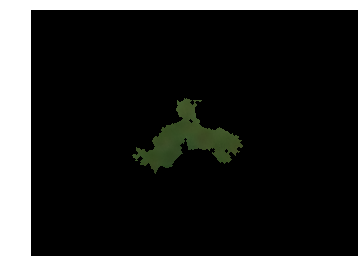

In [11]:
disk = morph.disk(1)
finMaskEroded = morph.binary_closing(finMask, disk).astype(float)

median = np.zeros((3))
for i in range(3):
  median[i] = np.median(useImage[:,:,i][finMaskEroded==1])

# Plotting/Displaying aspect
newImage = np.array(useImage).astype(float)

for i in range(3):
  newImage[:,:,i] = finMaskEroded * originalImage[:,:,i].astype(float) / 255.0

plt.axis('off')
io.imshow(newImage)
plt.savefig('inout3.eps')
plt.show()
#dw('out3.eps')

### Find same surface of shadowed region

Possible Issues:
  - Way to find the valley.
  - Uncomment bilateral filteral
  - Vectorize the `cosineImage` construction

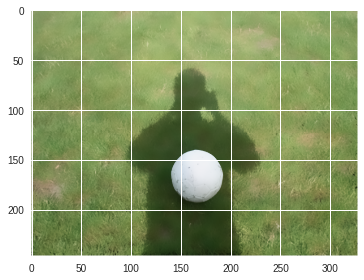

(array([53354, 21188,  2279,   566,   729,   341,   161,   127,  1717,
         554]), array([0.        , 0.00459358, 0.00918716, 0.01378074, 0.01837432,
       0.0229679 , 0.02756148, 0.03215506, 0.03674864, 0.04134222,
       0.0459358 ]))


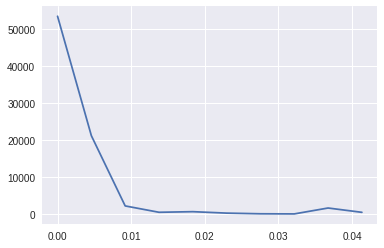

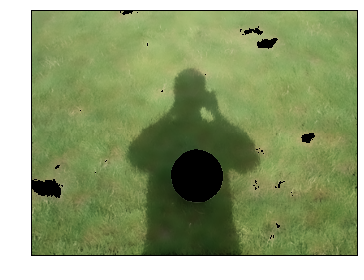

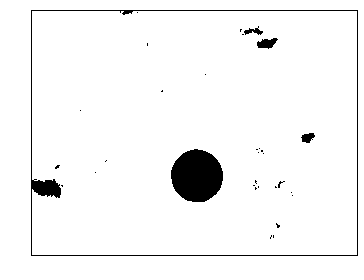

In [14]:
cosineImage = np.zeros(originalImage.shape[0:2])
filteredImage = np.array(originalImage)
# before 0.01
#filteredImage = denoise_bilateral(originalImage,sigma_color=0.04,
#                                  sigma_spatial=2,multichannel=True)

io.imshow(filteredImage)
plt.show()

for i in range(imx):
  for j in range(imy):
    cosineImage[i,j] = np.abs(cosine(originalImage[i,j].astype(int),median))    

#coslist = np.sort(cosineImage.ravel())
#plt.plot(coslist,np.arange(coslist.shape[0]))
#plt.show()

#cosineImage[cosineImage==np.inf] = 1
nhist = np.histogram(cosineImage.ravel())
print(nhist)
plt.plot(nhist[1][:10],nhist[0])
#plt.savefig('inout4.eps')
plt.show()
#dw('out4.eps')

oldCosineImage = np.array(cosineImage)

#threshold to find:
thresh = 0.02328596#0.01428596
thresh = nhist[1][3]
cosineImage[cosineImage < thresh] = 1
cosineImage[cosineImage != 1] = 0

# Plotting/Displaying aspect
newImage = np.array(originalImage)
for i in range(3):
  newImage[:,:,i] = cosineImage * originalImage[:,:,i]

plt.axis('off')
io.imshow(newImage,vmin=0,vmax=1)
#plt.savefig('inout5.eps')
plt.show()
#dw('out5.eps')

plt.axis('off')
io.imshow(cosineImage)
plt.show()

### Computing $M_s$ and $M_l$

Possible Issues

- Do with CbCr also

---

`cosineImage`: Mask for surface (shadowed and unshadowed)

`finMask`:  Shadow seed

`finMaskEroded`:  Eroded shadow seed

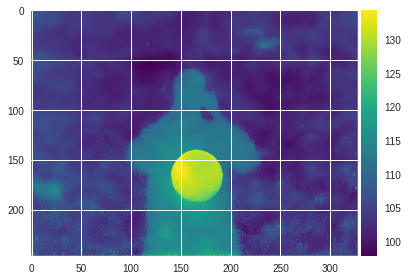

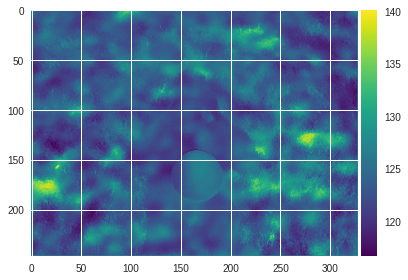

[]


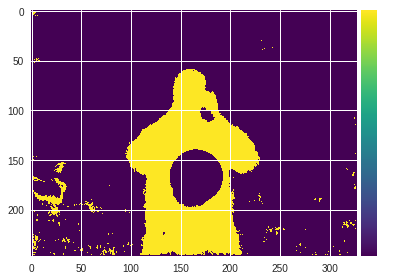

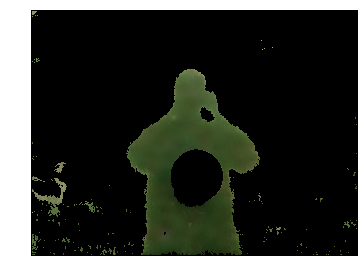

In [16]:
######temp
msMask = np.array(finMaskEroded).astype(int)
prev_msMask = np.array(msMask)

#filteredImage = denoise_bilateral(originalImage,sigma_color=0.04,
#                                  sigma_spatial=2,multichannel=True)
filteredImage = np.array(originalImage / 255.0)
ybrImage = color.rgb2ycbcr(filteredImage)

cb = ybrImage[:,:,1]
cr = ybrImage[:,:,2]

io.imshow(cb)
plt.show()

io.imshow(cr)
plt.show()

def similar_colours(a,b):
  
  mncb = (cb[:,:])[msMask==1].mean()
  mncr = (cr[:,:])[msMask==1].mean()

  if np.abs(cb[:,:][a]-mncb) + np.abs(cr[:,:][a]-mncr) <= thresh:
    return True
  return False

thresh = 0.001
add = 0
ls = []
ls2 = []

cont = 0

while True:
  
  # calculating sd of ms, ml
  x,y = np.where(msMask==1)
  ms_sd = ybrImage[x,y,0].std()
  
  x,y = np.where((cosineImage * (1-msMask))==1)
  ml_sd = ybrImage[x,y,0].std()
  
  ls2.append(ml_sd - ms_sd)
  
  #print(ml_sd - ms_sd)
  if ml_sd <= ms_sd:
    msMask = np.array(prev_msMask)
    break
    
  # region growing
  prev_msMask = np.array(msMask)
  added = 0
  
  mncb = (cb[:,:])[msMask==1].mean()
  mncr = (cr[:,:])[msMask==1].mean()
  
  points = np.abs(cb[:,:] - mncb) + np.abs(cb[:,:] - mncb)
  argsor = np.dstack(np.unravel_index(np.argsort(points.ravel()), points.shape))[0,:,:]
  iit,it = 0,0
  while iit < 10:
    x,y = argsor[it][0],argsor[it][1]
    it += 1
    if cosineImage[x,y] == 0 or msMask[x,y] == 1:
      continue
    msMask[x,y] = 1
    iit += 1
  
  #io.imshow(msMask)
  #plt.show()
  
  if cont == 50:
    break

print(ls)
### Display part
io.imshow(msMask,vmin=0,vmax=1)
plt.axis('off')
plt.show()

newIm = np.array(originalImage)
for i in range(3):
  newIm[:,:,i] = originalImage[:,:,i] * msMask
plt.axis('off')
io.imshow(newIm)
#plt.savefig('out6.eps')
plt.show()
#dw('out6.eps')

In [0]:
temp = np.array(msMask).astype(int)

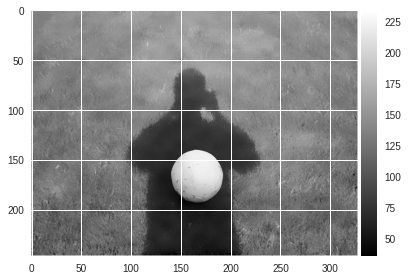

[]


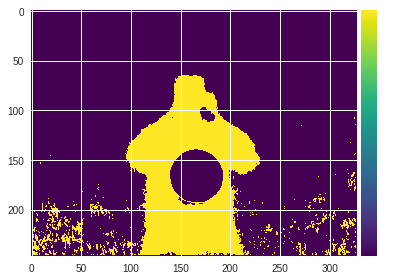

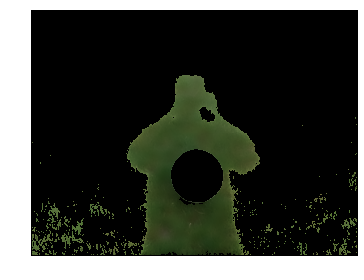

In [19]:
msMask = np.array(finMaskEroded).astype(int)
prev_msMask = np.array(msMask)
ybrImage = color.rgb2ycbcr(filteredImage)

io.imshow(ybrImage[:,:,0],cmap="gray")
plt.show()

def similar_colours(a,b):
  
  mn = (ybrImage[:,:,0])[msMask==1].mean()

  if ybrImage[:,:,0][a]-mn < thresh:
  #if ybrImage[:,:,0][a]-ybrImage[:,:,0][b] < thresh:
    return True
  return False

thresh = 0
add = 0
ls = []
ls2 = []
pre = 100

cont = 0

while True:
  
  # calculating sd of ms, ml
  x,y = np.where(msMask==1)
  ms_sd = ybrImage[x,y,0].std()
  
  x,y = np.where((cosineImage * (1-msMask))==1)
  ml_sd = ybrImage[x,y,0].std()
  
  ls2.append(ml_sd - ms_sd)
  
  #print(ml_sd - ms_sd)
  if ml_sd <= ms_sd:
    msMask = np.array(prev_msMask)
    break
    
  # region growing
  prev_msMask = np.array(msMask)
  added = 0
  
  mn = (ybrImage[:,:,0])[msMask==1].mean()
  
  points = np.abs(ybrImage[:,:,0]-mn)
  argsor = np.dstack(np.unravel_index(np.argsort(points.ravel()), points.shape))[0,:,:]
  iit,it = 0,0
  while iit < 10:
    x,y = argsor[it][0],argsor[it][1]
    it += 1
    if cosineImage[x,y] == 0 or msMask[x,y] == 1:
      continue
    msMask[x,y] = 1
    iit += 1
    
  if cont >= 10:
    break
  
  if pre < ml_sd - ms_sd and pre < 10:
    msMask = np.array(prev_msMask)
    break
  pre = ml_sd - ms_sd

print(ls)
### Display part
io.imshow(msMask,vmin=0,vmax=1)
plt.axis('off')
plt.show()    

newIm = np.array(originalImage)
for i in range(3):
  newIm[:,:,i] = originalImage[:,:,i] * msMask
plt.axis('off')
io.imshow(newIm)
#plt.savefig('out7.eps')
plt.show()
#dw('out7.eps')

In [0]:
tiembre = np.array(msMask).astype(int)

### Intersection of luma and chroma $M_s$ to compute final $M_s, M_l$

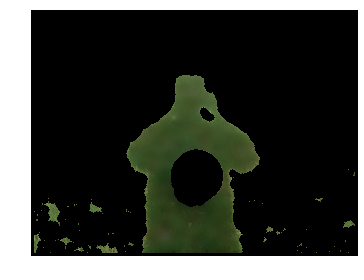

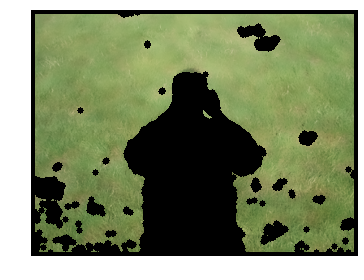

In [26]:
disk = morph.disk(3)
msMask_n = morph.binary_closing(tm, disk)
#msMask_n = tm

mlMask_n = cosineImage * (1-msMask_n)
mlMask_n = morph.binary_erosion(mlMask_n, disk)

# Display
tmp = np.array(originalImage)
for i in range(3):
  tmp[:,:,i] = msMask_n * tmp[:,:,i]
io.imshow(tmp)
plt.axis('off')
#plt.savefig('inout8new.eps')
#plt.savefig('inout8.png', dpi=400)
plt.show()
#dw('inout8new.eps')
#dw('inout8.png')

tmp = np.array(originalImage)
for i in range(3):
  tmp[:,:,i] = mlMask_n * tmp[:,:,i]
io.imshow(tmp)
plt.axis('off')
#plt.savefig('inout9new.eps')
#plt.savefig('inout9.png', dpi=400)
plt.show()
#dw('inout9new.eps')
#dw('inout9.png')

### Image Matting to compute $M_{shadow}$

Possible Issues:

- Might have to reduce the disk size back to 1 in previous step, and count number of bordering $M_l$ and $M_s$ pixels instead.

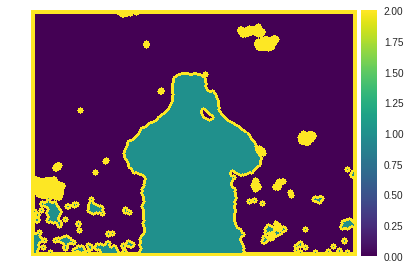

In [28]:
trimap = np.zeros(cosineImage.shape)
# 0:not shadow 1:shadow 2:rest
trimap[mlMask_n==1] = 1
trimap[msMask_n==1] = 1

def traverse(x,y,nm):
  Q = queue.Queue(100000)
  Q.put((x,y))
  if nm == 3:
    trimap[x,y] = 3
  
  while not Q.empty():
    x,y = Q.get()
    
    for j in neighbours:
      xn, yn = x + j[0], y + j[1]
      if xn<0 or xn>=imx or yn<0 or yn>=imy:
        continue
      if nm == 3 and mlMask_n[xn,yn] == 1:
        return 0
      if trimap[xn,yn] == 1:
        continue
      if nm == 3:
        if trimap[xn,yn] == 3:
          continue
        Q.put((xn,yn))
        trimap[xn,yn] = 3
      else:
        if trimap[xn,yn] == -1:
          continue
        Q.put((xn,yn))
        trimap[xn,yn] = -1
      
  return 1      
    

# initial: no ml around 3, else -1
for i in range(originalImage.shape[0]):
  for j in range(originalImage.shape[1]):
    if trimap[i,j] == 0:
      ret = traverse(i,j,3)
      if ret==0:
        traverse(i,j,-1)

trimap[mlMask_n==1] = 0
trimap[trimap==3] = 1
trimap[trimap==-1] = 2

# Display purposes        
plt.axis('off')
io.imshow(trimap)
plt.show()

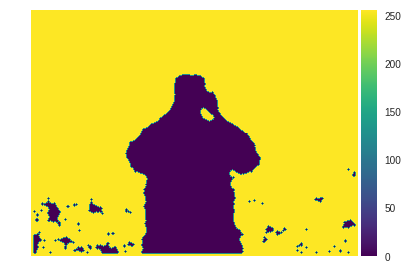

In [29]:
trimap[trimap!=1] = 0
temp = np.array(trimap)
disk = morph.disk(1)
temp = morph.binary_dilation(temp, disk)
trimap[temp==0] = 255
trimap[trimap==0] = 128
trimap[trimap==1] = 0

plt.axis('off')
io.imshow(trimap)
plt.show()

### Alpha Matting

Credits to https://github.com/MarcoForte/mishima-matting/

In [0]:
# Get fg/bg distances for each pixel from each surface on convex hull
def convex_hull_distance(cvx_hull, pixels):
    d_hull = np.ones(pixels.shape[0]*cvx_hull.equations.shape[0]).reshape(pixels.shape[0],cvx_hull.equations.shape[0])*1000
    for j, surface_eq in enumerate(cvx_hull.equations):
        for i, px_val in enumerate(pixels):
            nhat= surface_eq[:3]
            d_hull[i,j] = np.dot(nhat, px_val) + surface_eq[3]
    return  np.maximum(np.amax(d_hull, axis=1),0)

def mishima_matte(img, trimap):
    h,w,c = img.shape
    bg = trimap == 0
    fg = trimap == 255
    unknown = True ^ np.logical_or(fg,bg)
    fg_px = img[fg]
    bg_px = img[bg]
    unknown_px = img[unknown]

    # Setup convex hulls for fg & bg
    fg_hull = scipy.spatial.ConvexHull(fg_px)
    fg_vertices_px = fg_px[fg_hull.vertices]
    bg_hull = scipy.spatial.ConvexHull(bg_px)
    bg_vertices_px = bg_px[bg_hull.vertices]

    # Compute shortest distance for each pixel to the fg&bg convex hulls
    d_fg = convex_hull_distance(fg_hull, unknown_px)
    d_bg = convex_hull_distance(bg_hull, unknown_px)

    # Compute uknown region alphas and add to known fg.
    alphaPartial = d_bg/(d_bg+d_fg)
    alpha = unknown.astype(float).copy()
    alpha[alpha !=0] = alphaPartial
    alpha = alpha + fg
    return alpha

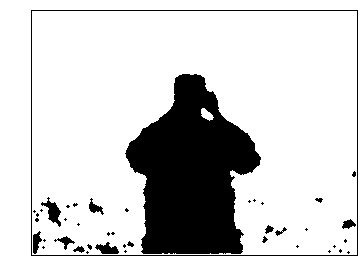

In [32]:
alpha = mishima_matte(originalImage.astype(float), trimap.astype(float))

##Display
#io.imshow(alpha)
#plt.show()
##

alpha[alpha>0.5] = 1
alpha[alpha!=1] = 0

##Display
#io.imshow(alpha)
#plt.axis('off')
#plt.show()

disk = morph.disk(1)
alpha = morph.binary_closing(alpha, disk)

##Display 
plt.axis('off')
io.imshow(alpha)
#plt.savefig('inout11new.eps')
#plt.savefig('inout11.png',dpi=400)
plt.show()
#dw('inout11new.eps')
#dw('inout11.png')